In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import glob
import pandas as pd
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [40]:
# Setupcloseur PBSCluster (Casper)
ncores=8
nmem='16GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UMSU0012', # Input your project ID here
    walltime='01:30:00', # Amount of wall time
    interface='mgt', # Interface to use
)

# Scale up
cluster.scale(ncores)

# Setup your client
client = Client(cluster)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42195 instead
  f"Port {expected} is already in use.\n"


In [48]:
client

<Client: 'tcp://10.18.206.54:34759' processes=8 threads=64, memory=119.20 GiB>

In [42]:
start_date = "1934-10-01"
end_date = "2010-09-30"
tdelta = slice(start_date, end_date)
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}

## Fluxes SA

In [122]:
tag = 'yampa'

In [123]:
runfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/quasi_random/quasi_random_2.main_run.txt'
runs = pd.read_csv(runfile, header=None)
runs = runs.values.ravel()
archivedir = '/glade/derecho/scratch/elkoukah/archive/'
pipelinedir = '/glade/derecho/scratch/elkoukah/pipeline/'

In [45]:
# Test if all runs are sccessful
caseprefix = '%s_quasi_random_2_' % tag
nrun = len(runs)
failed_runs = []
successful_runs = []
for i in range(1,nrun+1):
    casename = caseprefix+'%03i' % i
    if os.path.exists(archivedir+casename+'/'):
        ifiles = sorted(glob.glob(archivedir+casename+'/lnd/hist/*.h1.*'))
        # print(i, len(ifiles))
        successful_runs.append(len(ifiles))
    else:
        failed_runs.append(casename)

In [124]:
my_paramfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/my_sel_params_round3.csv'
df_param = pd.read_csv(my_paramfile, index_col='name')
sample = np.load('/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/sample_radial_oat_iter_1.npy')
nrun = sample.shape[0]

In [125]:
sample.shape

(11264, 20)

In [127]:
k = 20
r = 512
A = sample[:r]
C = sample[r:-r].reshape(r,k,k)
B = sample[-r:]

In [128]:
A.shape, C.shape, B.shape

((512, 20), (512, 20, 20), (512, 20))

In [17]:
dsh1 = xr.open_dataset('/glade/derecho/scratch/elkoukah/pipeline/%s_radial_variance_1.h1.nc'%tag, chunks={'record':512})

In [18]:
vars=['QRUNOFF','QOVER','QDRAI','EFLX_LH_TOT','QVEGT','QSOIL','FPSN','FSH']
dsh_ens = dsh1[vars].sel(time=tdelta)

In [19]:
dsh_ens_vartot = xr.open_dataset('/glade/derecho/scratch/elkoukah/pipeline/%s_radial_variance_1.vtot.nc'%tag)

In [20]:
vtot = dsh_ens_vartot.assign()
vtot_nonzero = vtot.where(vtot>0)

In [21]:
sa_list = []
ai = np.array([ri for ri in range(r)])
bbi = ai+(r*(k+1))
bidx = np.arange(r*k)+r
for ki in range(k):
    print('processing ki =', ki)
    bi = bidx[ki::k]
    idx = np.hstack([ai,bi,bbi])
    dsh_idx = dsh_ens.isel(record=idx)

    dsha = dsh_idx.isel(record=slice(0,512))
    dshb = dsh_idx.isel(record=slice(512,512*2))
    dshbb = dsh_idx.isel(record=slice(512*2,512*3))
    df_sti = (dsha-dshb)**2
    df_si = dshbb*(dshb-dsha)
    Sti = df_sti.sum('record') * 1/(2*r*vtot_nonzero)
    Si = df_si.sum('record') * 1/(r*vtot_nonzero)
    sa_da = xr.concat([Sti, Si], dim='sa')
    sa_list.append(sa_da)
    break

processing ki = 0


In [47]:
sa_compute = dask.compute(*sa_list)

In [206]:
# ds_sa = xr.concat(sa_list, dim='ki')
ds_sa = xr.concat(sa_compute, dim='ki')
ofile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/%s_SA.nc'%tag
ds_sa.to_netcdf(ofile, 'w')

# Runoff climate sensitivities

In [73]:
from sklearn import linear_model
def calc_clim_sens(dprec_wy, davtemp_wy, dqobs_wy):
    X = np.stack([dprec_wy[1:],
                  davtemp_wy[1:],
                  dqobs_wy[:-1],
                 ])
    Y = dqobs_wy[1:]
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    return alpha, beta, s

In [112]:
nrun = 11264
cols = ['alpha','beta', 'sigma', 'rratio']
ncol = len(cols)
arr_metrics = np.full((3,nrun,ncol), np.nan)
for j, tag in enumerate(stids.keys()):
    # meteo variables
    metfile = '/glade/derecho/scratch/elkoukah/inputs/ucrb/headwaters/%s/%s_livneh_1915-2018.nc'%(tag,tag)
    ds_met = xr.open_dataset(metfile)
    ds_met_tdelta = ds_met.sel(time=tdelta).isel(lat=0,lon=0)
    prec = ds_met_tdelta['prec']
    avtemp = (ds_met_tdelta['tmax']+ds_met_tdelta['tmin'])/2
    prec_wy = prec.resample(time='A-SEP').mean()
    avtemp_wy = avtemp.resample(time='A-SEP').mean()
    dprec_wy = (prec_wy-prec_wy.mean().data)/prec_wy.mean().data
    davtemp_wy = avtemp_wy-avtemp_wy.mean().data

    ifile = '/glade/derecho/scratch/elkoukah/pipeline/%s_radial_variance_1.h1.nc'%tag
    dsh1 = xr.open_dataset(ifile, chunks={'record':512})
    rof_mdl = dsh1['QRUNOFF'].sel(time=tdelta, lndgrid=0)*24*60**2 #mm/day
    rof_mdl_wy = rof_mdl.resample(time='A-SEP').mean().compute()
    mu = rof_mdl_wy.mean('time')
    drof_mdl_wy = (rof_mdl_wy-mu)/mu
    rratio_sim = rof_mdl_wy.mean('time').data/prec.mean('time').data
    arr_metrics[j,:,-1] = rratio_sim
    for i in range(nrun):
        alpha_sim, beta_sim, s_sim = calc_clim_sens(dprec_wy.data, davtemp_wy.data, drof_mdl_wy.data[i])
        arr_metrics[j,i,:-1] = np.array([alpha_sim, beta_sim, s_sim])

(array([  15.,   32.,  276.,  817., 1935., 2787., 2826., 1767.,  715.,
          94.]),
 array([-0.08604397, -0.08195147, -0.07785897, -0.07376647, -0.06967397,
        -0.06558147, -0.06148897, -0.05739647, -0.05330397, -0.04921147,
        -0.04511897]),
 <BarContainer object of 10 artists>)

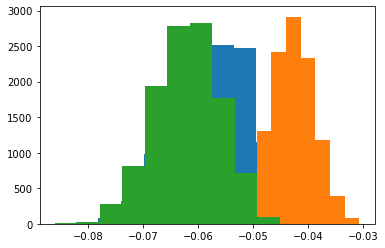

In [118]:
plt.hist(arr_metrics[0,:,1])
plt.hist(arr_metrics[1,:,1])
plt.hist(arr_metrics[2,:,1])

In [120]:
ds_metrics = xr.Dataset({'yampa':(('run','metric'), arr_metrics[0]),
                         'east':(('run','metric'), arr_metrics[1]),
                         'animas':(('run','metric'), arr_metrics[2])}, 
                         attrs={'metrics':cols})
ofile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/ens_metrics.nc'
ds_metrics.to_netcdf(ofile)